# 基于MindSpore实现图像分类示例
本实验是基于MindSpore的框架，生成数据，然后实现图像分类。

## 1.实验目的
- 了解MindSpore的数据集，并学会下载和使用。
- 了解和掌握基于MindSpore框架下神经网络的搭建。
- 掌握基于MindSpore框架下的图片分类算法。
- 掌握图像分类神经网络算法原理。
- 掌握神经网络模型的搭建、训练和预测的整个流程。

## 2.模型介绍
自定义一个[LeNet-5网络分类模型](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=726791)可查看[论文](http://www.iro.umontreal.ca/~lisa/bib/pub_subject/language/pointeurs/lecun-01a.pdf)，数据经过两次卷积，激活，最大池化后，对其进行展平操作，然后输入两个全链接层，分别用ReLU激活，再输入到输出层得到结果。
- 卷积层：其主要作用是提取图像中的特征，浅层卷积层用来提取边缘、纹理等特征，深层卷积层用来提取更加抽象的特征，整合在一起构成了丰富的图像特征。
- 激活函数：是一种添加到人工神经网络中的函数，旨在帮助网络学习数据中的复杂模式。类似于人类大脑中基于神经元的模型，激活函数最终决定了要发射给下一个神经元的内容。
- 最大池化层：池化是卷积神经网络中的一个重要的概念，是一种形式的降采样。有多种不同形式的非线性池化函数，池化层会不断地减小数据的空间大小，因此参数的数量和计算量也会下降，这在一定程度上也控制了过拟合。通常来说，CNN的卷积层之间都会周期性地插入池化层。池化一般有三种形式，最大池化，最小池化和平均池化，这里采用的是最大池化。
- 展平操作：将数据展平为适合神经网络的结构，用于输入层或者卷积层和全连接层中间。此处使用展平层是因为图片经过卷积操作后，仍然是一个二维矩阵，此类数据不适合直接输入至全链接层，因此需要将其展平为一维向量。
- 全链接层：在整个卷积神经网络中起到“分类器”的作用。如果说卷积层、池化层和激活函数层等操作是将原始数据映射到隐层特征空间的话，全连接层则起到将学到的“分布式特征表示”映射到样本标记空间的作用。

模型图如下所示：
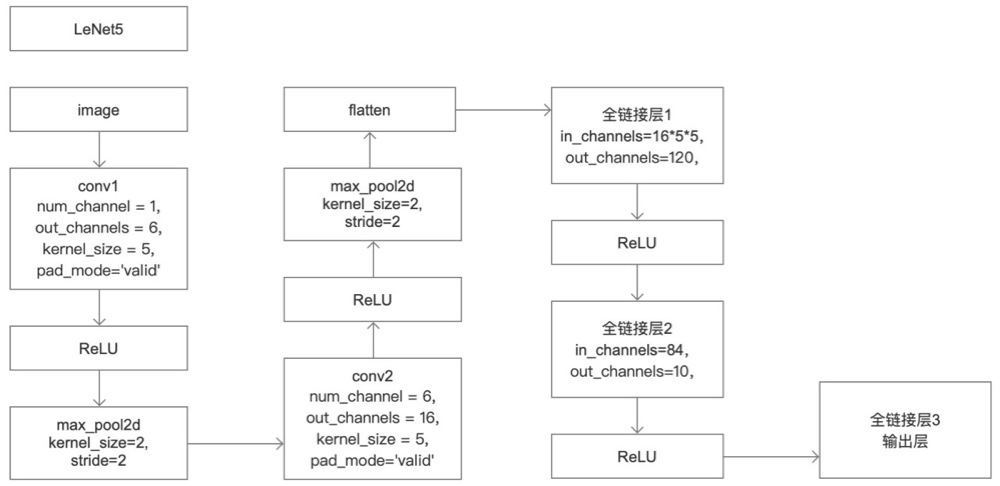

# 3、 实验环境
在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=MindSpore 2.0；Python环境=3.7


|  硬件平台 |  操作系统  | 软件环境 | 开发环境 | 环境搭建链接 |
| :-----:| :----: | :----: |:----:   |:----:   |
| CPU | Windows-x64 | MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| GPU CUDA 10.1|Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.2节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|

## 4.数据处理
### 4.1数据准备
该试验为图像分类实验，使用的数据集是MNIST，是一个经典的大型手写数字图像数据集，来自美国国家标准与技术研究所，由不同人手写的0至9的数字构成，拥有60,000张训练图像和10,000张测试图像，所有图像都是28×28的灰度图像，每张图像包含一个手写数字，以二进制格式存储，常用于训练各种图像处理系统。<br>
共10个类别，每个类别代表0~9之间的一个数字，每张图像只有一个类别。<br>
MNIST手写数字识别模型的主要任务是：输入一张手写数字的图像，然后识别图像中手写的是哪个数字。



目录结构如下：<br>
└── mnist_dataset_dir<br>
    ├── t10k-images-idx3-ubyte<br>
    ├── t10k-labels-idx1-ubyte<br>
    ├── train-images-idx3-ubyte<br>
    └── train-labels-idx1-ubyte<br>
生成的数据集有两列: [image, label]。 image列的数据类型为uint8。 label 列的数据类型为uint32。

In [1]:
# 处理文件和目录
import os
# 该模块提供了加载和处理各种通用数据集的API
from mindspore import dataset as ds
# 此模块用于图像数据增强
import mindspore.dataset.vision as CV
# 图像插值方式枚举类
from mindspore.dataset.vision import Inter
# 此模块用于通用数据增强
import mindspore.dataset.transforms as C
# MindSpore数据类型的对象
from mindspore import dtype as mstype
# 绘图库
import matplotlib.pyplot as plt
# 数据下载
from mindspore.dataset import MnistDataset

### 4.2数据加载
下载MindSpore的内置数据集MNIST，并对其进行一系列预处理操作，作为训练和测试的数据。<br>
先从MindSpore下载数据集，然后分别获取训练集和测试集，再传入到create_dataset()数据处理函数中进行处理，得到处理后的训练集和测试集，分别用于后续的模型训练和测试。

In [2]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:04<00:00, 2.51MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


In [3]:
train_dataset = MnistDataset("MNIST_Data/train", shuffle=False)
test_dataset = MnistDataset("MNIST_Data/test", shuffle=False)

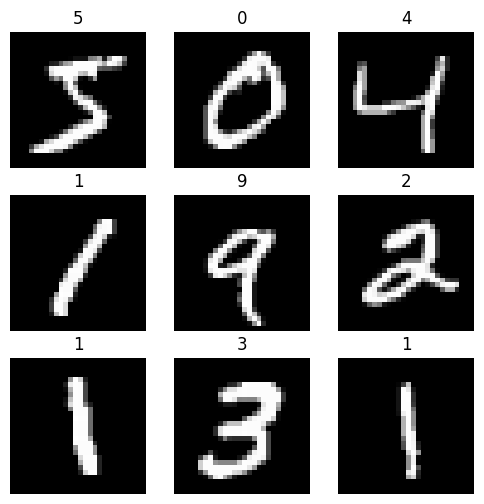

In [4]:
# 查看训练集数据
def visualize(dataset):
    figure = plt.figure(figsize=(6, 6))
    cols, rows = 3, 3

    for idx, (image, label) in enumerate(dataset.create_tuple_iterator()):
        figure.add_subplot(rows, cols, idx + 1)
        plt.title(int(label))
        plt.axis("off")
        plt.imshow(image.asnumpy().squeeze(), cmap="gray")
        if idx == cols * rows - 1:
            break
    plt.show()

visualize(train_dataset)

In [5]:
def create_dataset(mnist_ds, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    # 为训练和测试生成数据集
    # 参数:
    # mnist_ds: 数据集
    # batch_size: 指定每个批处理数据包含的数据条目。
    # repeat_size: 数据集重复次数
    # num_parallel_workers: 指定map操作的多进程/多线程并发数，加快处理速度
    # 定义数据集
    # 生成的数据集有两列: [image, label]。 image 列的数据类型为uint8。 label 列的数据类型为uint32。
    # 定义操作参数
    # 调整后图片的尺寸
    resize_height, resize_width = 32, 32  
    # 缩放因子
    rescale = 1.0 / 255.0   
    # 平移因子
    shift = 0.0   
    # 标准化图像缩放因子
    rescale_nml = 1 / 0.3081   
    # 标准化图像平移因子
    shift_nml = -1 * 0.1307 / 0.3081         

    # 定义映射操作
    # 调整图片尺寸为 (32, 32)，interpolation线性插值
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    # 标准化图片
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml) 
    # 重新缩放图像
    rescale_op = CV.Rescale(rescale, shift) 
    # 将输入图像的shape从 <H, W, C> 转换为 <C, H, W>。 如果输入图像的shape为 <H, W> ，图像将保持不变。
    hwc2chw_op = CV.HWC2CHW() 
    # 将输入的Tensor转换为指定的数据类型。
    type_cast_op = C.TypeCast(mstype.int32) 

    # 将定义好的映射操作依次应用在数据集上。
    # 将输入的Tensor转换为指定的mstype.int32类型，输入数据为“label”列，num_parallel_workers指定线程并发数，此处为单线程处理。
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    # 调整图片的尺寸为（32，32），输入数据为“image”列
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    # 缩放图像，输入数据为“image”列，输出图像的像素大小为：output = image * rescale + shift。
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    # 标准化图像，输入数据为“image”列，输出图像的像素大小为：output = image * rescale_nml + shift_nml。
    mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    # 将输入图像的shape从 <High, Wide, Channel> 转换为 <Channel, High, Wide>。 如果输入图像的shape为 <High, Wide> ，图像将保持不变。
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)

    # 应用数据集操作
    # 混洗缓冲区大小
    buffer_size = 10000
    # 混洗数据集
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size) 
    # batch操作将数据集中连续 batch_size 条数据组合为一个批数据，并可通过可选参数 per_batch_map 指定组合前要进行的预处理操作。
    # drop_remainder，当最后一个批处理数据包含的数据条目小于 batch_size 时，是否将该批处理丢弃，不传递给下一个操作。默认值：False，不丢弃。此处为True，丢弃。
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    # 重复此数据集 repeat_size 次。如果 repeat_size 为None或-1，则无限重复迭代。
    mnist_ds = mnist_ds.repeat(repeat_size)
    
    # 返回处理好的数据集
    return mnist_ds

In [6]:
# 查看训练数据集
ds_train = create_dataset(train_dataset, 32, 1)

# 下载测试数据集
ds_eval = create_dataset(test_dataset)
print("dataset handled over")

dataset handled over


# 5.构建模型
根据以上对模型的介绍，基于MindSpore框架，构建该模型，实现图片分类。

In [7]:
# 神经网络Cell，用于构建神经网络中的预定义构建块或计算单元。
import mindspore.nn as nn
import mindspore as ms
# Model建立模型
# load_checkpoint加载checkpoint文件
# load_param_into_net将参数加载到网络中，返回网络中没有被加载的参数列表。
from mindspore import load_checkpoint, load_param_into_net
# 生成一个服从正态分布 N(sigma,mean) 的随机数组用于初始化Tensor
from mindspore.common.initializer import Normal
# ModelCheckpointcheckpoint的回调函数，在训练过程中调用该方法可以保存网络参数。
# CheckpointConfig保存checkpoint时的配置策略。
# LossMonitor训练场景下，监控训练的loss；边训练边推理场景下，监控训练的loss和推理的metrics。
# Accuracy计算数据分类的正确率，包括二分类和多分类。
from mindspore.train import Model, ModelCheckpoint, CheckpointConfig, LossMonitor, Accuracy
# from mindspore.nn.metrics import Accuracy
# 计算预测值与真实值之间的交叉熵。
from mindspore.nn import SoftmaxCrossEntropyWithLogits

In [8]:
class LeNet5(nn.Cell):
    # Lenet 网络结构
    # 定义需要的操作
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        # 对输入Tensor计算二维卷积，输入空间维度in_channels为num_channel，输出空间维度out_channels为6，kernel_size为5
        #pad_mode (str) - 指定填充模式。可选值为”same”、”valid”、”pad”。默认值：”same”。
        #same：输出的高度和宽度分别与输入整除 stride 后的值相同。若设置该模式，padding 的值必须为0。
        #valid：在不填充的前提下返回有效计算所得的输出。不满足计算的多余像素会被丢弃。如果设置此模式，则 padding 的值必须为0。
        #pad：对输入进行填充。在输入的高度和宽度方向上填充 padding 大小的0。如果设置此模式， padding 必须大于或等于0。
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        # 对输入Tensor计算二维卷积，in_channels=6，out_channels=16，kernel_size=5
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        # 全连接层，适用于输入的密集连接层。
        # Dense层输入Tensor的空间维度in_channels=16 * 5 * 5，Dense层输出Tensor的空间维度out_channels=120，
        # weight_init权重参数初始化，Normal(0.02)生成一个正太分布的随机数
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        # Dense层in_channels=120，out_channels=84。
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        # Dense层in_channels=84，out_channels=num_class，此处为10。
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        # 定义激活函数为ReLU
        self.relu = nn.ReLU()
        # 定义最大二维池化，卷积核尺寸为2，步长为2
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # 对输入Tensor的第零维之外的维度进行展平操作。
        self.flatten = nn.Flatten()

    # 网络构造函数，使用上面定义的操作来构建网络
    def construct(self, x):
        # 对输入数据进行self.conv1卷积操作后，self.relu激活，再self.max_pool2d最大2维池化
        x = self.max_pool2d(self.relu(self.conv1(x)))
        # 对输入数据进行self.conv2卷积操作后，self.relu激活，再self.max_pool2d最大2维池化
        x = self.max_pool2d(self.relu(self.conv2(x)))
        # 对输入数据进行展平操作
        x = self.flatten(x)
        # 输入数据经过self.fc1全链接层处理后，self.relu函数激活
        x = self.relu(self.fc1(x))
        # 输入数据经过self.fc2全链接层处理后，self.relu函数激活
        x = self.relu(self.fc2(x))
        # 对输入数据进行self.fc3全链接层处理
        x = self.fc3(x)
        return x

In [9]:
# 创建网络模型
net = LeNet5()

# 6.训练模型
基于上面给出的网络模型的构建，使用下载好的MNIST数据集中的训练数据来训练上面创建的模型net。

In [10]:
# 设置运行环境的context。
ms.set_context(mode=0, device_target="CPU")
dataset_sink_mode = False
# 设置学习率lr
lr = 0.01
# 设置移动平均的动量
momentum = 0.9
# 设置数据集重复次数
dataset_size = 1
# 数据下载路径
mnist_path = "./MNIST_Data"
# 定义损失函数，计算预测值与真实值之间的交叉熵。
# sparse (bool) - 指定目标值是否使用稀疏格式。默认值：False。
# reduction (str) - 指定应用于输出结果的计算方式。取值为”mean”，”sum”，或”none”。取值为”none”，则不执行reduction。默认值：”none”。
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# 定义训练执行轮次
train_epoch = 1

# 定义优化器
net_opt = nn.Momentum(net.trainable_params(), lr, momentum)
# 保存checkpoint时的配置策略，
# save_checkpoint_steps (int) - 每隔多少个step保存一次checkpoint。默认值：1。
# keep_checkpoint_max (int) - 最多保存多少个checkpoint文件。默认值：5。
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
# 保存网络模型和参数以进行子序列微调
# prefix (str) - checkpoint文件的前缀名称。默认值：’CKP’
# config (CheckpointConfig) - checkpoint策略配置。默认值：None。
ckpoint = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)
# 将层分组到具有训练和评估特征的对象中，输出参数指定输出精确度
model = Model(net, net_loss, net_opt, metrics={"Accuracy": Accuracy()})

In [11]:
# 定义训练方法
def train_net(ds_train, network_model, epoch_size, data_path, repeat_size, ckpoint_cb, sink_mode):
    print("============== Starting Training ==============")
    # 训练执行轮次epoch_size，训练数据集ds_train
    # callbacks (Optional[list[Callback], Callback]) - 训练过程中需要执行的回调对象或者回调对象列表。默认值：None。
    # dataset_sink_mode (bool) - 数据是否直接下沉至处理器进行处理。使用PYNATIVE_MODE模式或CPU处理器时，模型训练流程将以非下沉模式执行。默认值：False。
    network_model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(per_print_times=75)], dataset_sink_mode=sink_mode)

In [12]:
#调用训练方法
train_net(ds_train, model, train_epoch, mnist_path, dataset_size, ckpoint, dataset_sink_mode)

============== Starting Training ==============
epoch: 1 step: 75, loss is 2.306429147720337
epoch: 1 step: 150, loss is 2.306762456893921
epoch: 1 step: 225, loss is 2.2805213928222656
epoch: 1 step: 300, loss is 2.301910400390625
epoch: 1 step: 375, loss is 2.318624973297119
epoch: 1 step: 450, loss is 2.316574811935425
epoch: 1 step: 525, loss is 2.303313732147217
epoch: 1 step: 600, loss is 2.320096731185913
epoch: 1 step: 675, loss is 2.296616792678833
epoch: 1 step: 750, loss is 2.306187152862549
epoch: 1 step: 825, loss is 2.1066501140594482
epoch: 1 step: 900, loss is 1.2701985836029053
epoch: 1 step: 975, loss is 0.4199488162994385
epoch: 1 step: 1050, loss is 0.6758994460105896
epoch: 1 step: 1125, loss is 0.2769855260848999
epoch: 1 step: 1200, loss is 0.10871347039937973
epoch: 1 step: 1275, loss is 0.11824130266904831
epoch: 1 step: 1350, loss is 0.16152462363243103
epoch: 1 step: 1425, loss is 0.5210810303688049
epoch: 1 step: 1500, loss is 0.18698401749134064
epoch: 1 st

# 7.模型预测
在上面模型训练好的情况下，输入测试数据集对模型进行评估，输出其分类的精确度

In [13]:
def test_net(ds_eval, network, network_model, data_path):
    # 定义测试方法
    print("============== Starting Testing ==============")
    # 下载并保存模型用以评估
    param_dict = load_checkpoint("checkpoint_lenet-1_1875.ckpt")
    # 将参数加载到网络中，返回网络中没有被加载的参数列表
    load_param_into_net(network, param_dict)
    # 获取测试结果的精确度并输出。
    acc = network_model.eval(ds_eval, dataset_sink_mode=False)
    print("============== Accuracy:{} ==============".format(acc))

In [14]:
# 调用测试方法
test_net(ds_eval, net, model, mnist_path)

============== Starting Testing ==============
============== Accuracy:{'Accuracy': 0.9770633012820513} ==============
